In [2]:
import inspect
import time
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from IPython.display import VimeoVideo
from pymongo import MongoClient
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings("ignore")


In [3]:
def wrangle(filepath):

    # Read CSV file
    df = pd.read_csv(filepath)
    
    # Drop a  all column
    df = df.drop(columns=["unix",'symbol','low','open','high','Volume BTC','Volume USD'])


    # Convert date column to datetime format
    df["date"] = pd.to_datetime(df["date"])

    # Set date column as index
    df.set_index("date", inplace=True)

    # Localize timezone
    #df.index = df.index.tz_localize("UTC")

    # Remove outliers
    #df = df[df["P2"] < 500]

    # Filter DataFrame to include only rows with date after 2022
    df = df.loc[df.index > '2022-01-01']

    # Resample to 1day window
    y = df["close"].resample("1D").mean().fillna(method='ffill')

    return y

In [4]:
y=wrangle(r'C:\Users\Nassoh\Desktop\DataSienceMyProject\BTC Price\Data\BTCUSD_day.csv')
y.shape

(479,)

# Split

In [5]:
Prediction=y.shape[0]-7
cutoff_test =int(Prediction)
y_train =y.iloc[:cutoff_test]
y_test =y.iloc[cutoff_test:]
y_train

date
2022-01-02    47350.22
2022-01-03    46439.89
2022-01-04    45820.00
2022-01-05    43435.80
2022-01-06    43097.60
                ...   
2023-04-14    30498.00
2023-04-15    30332.00
2023-04-16    30330.00
2023-04-17    29448.00
2023-04-18    30395.00
Freq: D, Name: close, Length: 472, dtype: float64

In [6]:
y_test

date
2023-04-19    28827.0
2023-04-20    28238.0
2023-04-21    27254.0
2023-04-22    27817.0
2023-04-23    27596.0
2023-04-24    27512.0
2023-04-25    27521.0
Freq: D, Name: close, dtype: float64

# Baseline

In [7]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
print("Mean BTC Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean BTC Reading: 27169.35
Baseline MAE: 8023.76


# Model

In [8]:
# Create ranges for possible  𝑝 and  𝑞 values
p_params = range(0,25,8)
q_params = range(0,3,1)

In [9]:
print(list(p_params))
print(list(q_params))

[0, 8, 16, 24]
[0, 1, 2]


In [10]:
# Create dictionary to store MAEs
mae_grid = dict()
# Outer loop: Iterate through possible values for `p`
for p in p_params:
    # Create key-value pair in dict. Key is `p`, value is empty list.
    mae_grid[p] = list()
    # Inner loop: Iterate through possible values for `q`
    for q in q_params:
        # Combination of hyperparameters for model
        order = (p, 0, q)
        # Note start time
        start_time = time.time()
        # Train model
        model =ARIMA(y_train,order=order).fit()
        # Calculate model training time
        elapsed_time = round(time.time() - start_time, 2)
        print(f"Trained ARIMA {order} in {elapsed_time} seconds.")
        # Generate in-sample (training) predictions
        y_pred =model.predict()
        # Calculate training MAE
        mae =mean_absolute_error(y_train,y_pred)
        # print mae 
        print("MAE : ",mae)
        # Append MAE to list in dictionary
        mae_grid[p].append(mae)

print()
print(mae_grid)

Trained ARIMA (0, 0, 0) in 0.04 seconds.
MAE :  8023.763965096236
Trained ARIMA (0, 0, 1) in 0.24 seconds.
MAE :  4194.391274726669
Trained ARIMA (0, 0, 2) in 0.56 seconds.
MAE :  2632.650175216127
Trained ARIMA (8, 0, 0) in 0.48 seconds.
MAE :  656.4148237161825
Trained ARIMA (8, 0, 1) in 0.8 seconds.
MAE :  655.2734455840232
Trained ARIMA (8, 0, 2) in 1.39 seconds.
MAE :  663.4980352361491
Trained ARIMA (16, 0, 0) in 1.79 seconds.
MAE :  656.1127836498395
Trained ARIMA (16, 0, 1) in 2.18 seconds.
MAE :  656.1179762527655
Trained ARIMA (16, 0, 2) in 2.66 seconds.
MAE :  654.0668154629616
Trained ARIMA (24, 0, 0) in 7.26 seconds.
MAE :  654.6105660064904
Trained ARIMA (24, 0, 1) in 5.35 seconds.
MAE :  655.0088293355142
Trained ARIMA (24, 0, 2) in 7.33 seconds.
MAE :  655.0786809724377

{0: [8023.763965096236, 4194.391274726669, 2632.650175216127], 8: [656.4148237161825, 655.2734455840232, 663.4980352361491], 16: [656.1127836498395, 656.1179762527655, 654.0668154629616], 24: [654.61056

# Best params
 Trained ARIMA (8, 0, 1) in 10.33 seconds.
 MAE :  108.04601258159315
 p=8 , q=1

In [11]:
mae_df =pd.DataFrame(mae_grid)
mae_df.round(4)

,0,8,16,24
0,8023.7640,656.4148,656.1128,654.6106
1,4194.3913,655.2734,656.1180,655.0088
2,2632.6502,663.4980,654.0668,655.0787


In [12]:
sns.heatmap(mae_df)
plt.xlabel('p values')
plt.ylabel('q values')
plt.title('ARMA Grid Search (MAE)')

Text(0.5, 1.0, 'ARMA Grid Search (MAE)')

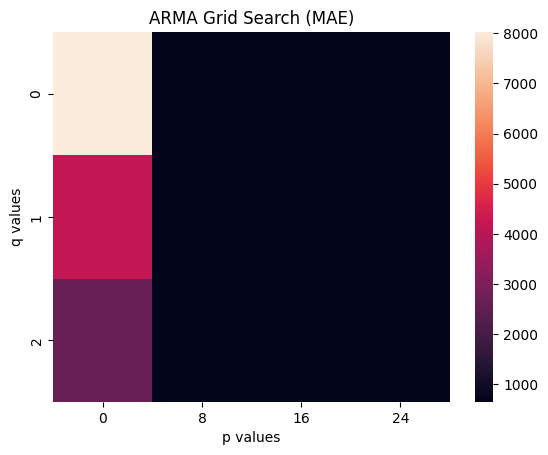

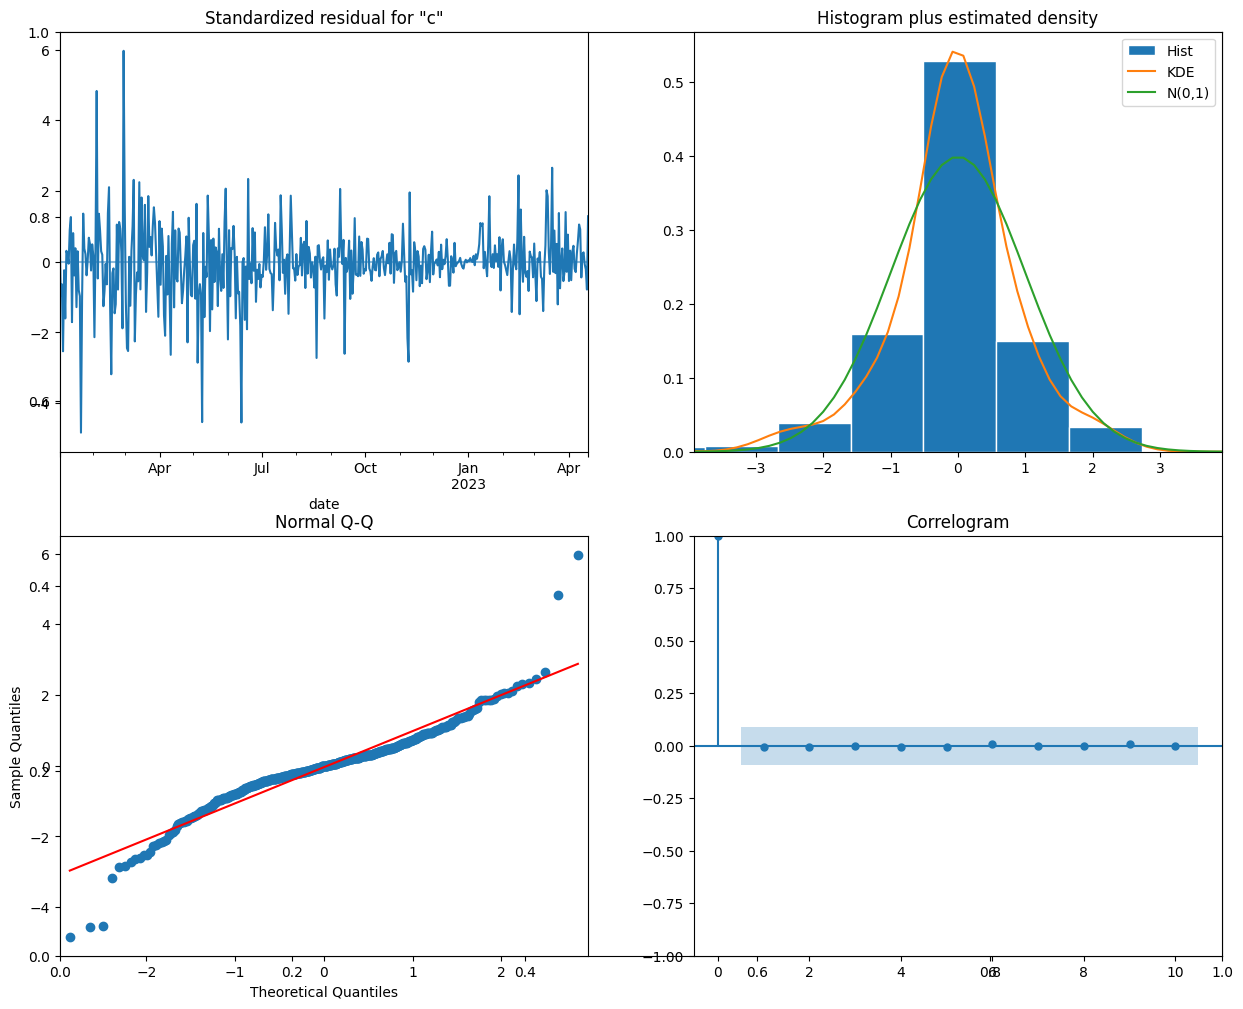

In [13]:
fig, ax = plt.subplots(figsize=(15, 12))
model.plot_diagnostics(fig=fig)
plt.show()

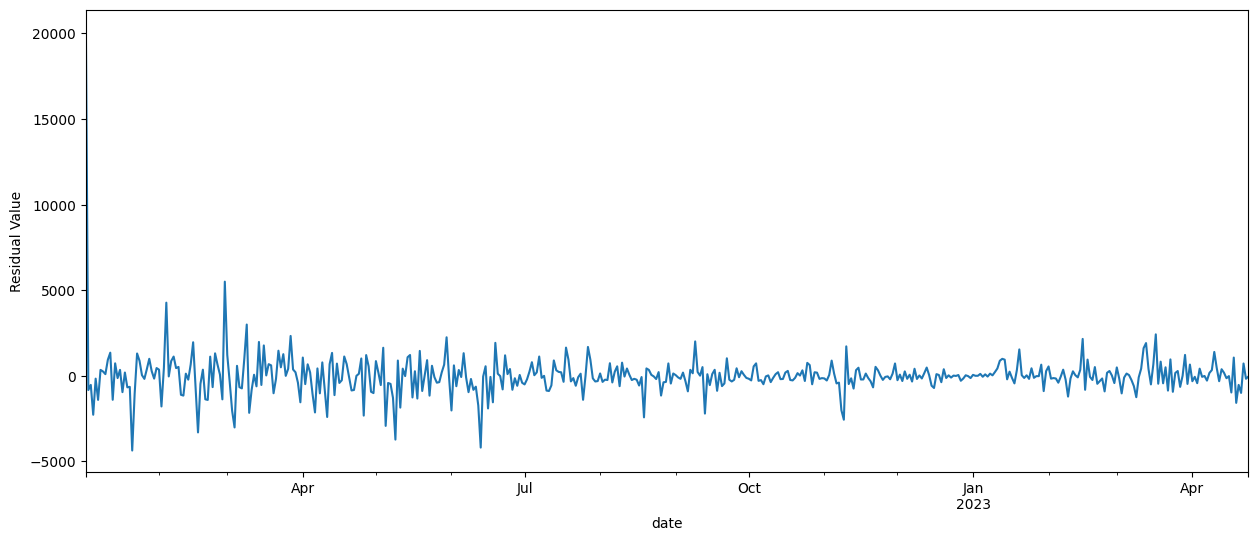

In [29]:
y_train_resid =model.resid
fig, ax = plt.subplots(figsize=(15, 6))
y_train_resid.plot(ylabel='Residual Value',ax=ax)
plt.show()

# Evaluate

In [15]:
model =ARIMA(y_train,order=(8,0,1)).fit()

In [16]:
y_pred_train =model.predict(y_train.index.min(),y_train.index.max())
training_mae =mean_absolute_error(y_train,y_pred_train)

In [17]:
y_pred_test =model.predict(y_test.index.min(),y_test.index.max())
test_mae =mean_absolute_error(y_test,y_pred_test)
print("Baseline MAE:", round(mae_baseline, 2))
print("Training MAE:", training_mae)
print("Test MAE:", test_mae)

Baseline MAE: 8023.76
Training MAE: 655.2734455840232
Test MAE: 2590.4941152290426


In [18]:
df_pred_train = pd.DataFrame(
    {"y_train": y_train, "y_pred_train": y_pred_train},
)
df_pred_train

,y_train,y_pred_train
date,,
2022-01-02,47350.22,27169.346338
2022-01-03,46439.89,47279.915135
2022-01-04,45820.00,46356.593020
2022-01-05,43435.80,45721.694913
2022-01-06,43097.60,43265.125640
...,...,...
2023-04-14,30498.00,30321.629965
2023-04-15,30332.00,30479.539450
2023-04-16,30330.00,30352.594410


In [19]:
fig = px.line(df_pred_train, labels={"value": "BTC"},title='Train Data')
fig.show()

In [20]:
df_pred_test = pd.DataFrame(
    {"y_test": y_test, "y_pred": y_pred_test},
)
df_pred_test

,y_test,y_pred
2023-04-19,28827.0,30427.039048
2023-04-20,28238.0,30392.641225
2023-04-21,27254.0,30471.245093
2023-04-22,27817.0,30443.732842
2023-04-23,27596.0,30389.571803
2023-04-24,27512.0,30337.756898
2023-04-25,27521.0,30436.471899


In [21]:
fig = px.line(df_pred_test, labels={"value": "BTC"},title='Test Data')
fig.show()

In [22]:
y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model =ARIMA(history,order=(8,0,1)).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])

In [23]:
test_mae =mean_absolute_error(y_test,y_pred_wfv)
print("Baseline MAE:", round(mae_baseline, 2))
print("Training MAE:", training_mae)
print("Test MAE:", test_mae)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Baseline MAE: 8023.76
Training MAE: 655.2734455840232
Test MAE: 608.7145529500776
Test MAE (walk forward validation): 608.71


In [24]:
df_predictions =pd.DataFrame({'y_test':y_test,'y_pred_wfv':y_pred_wfv})
fig =px.line(df_predictions,labels={'value':'BTC'})
fig.show()

In [25]:
model.params

const      27178.191287
ar.L1          0.174959
ar.L2          0.862795
ar.L3          0.042970
ar.L4         -0.064872
ar.L5         -0.080798
ar.L6          0.052257
ar.L7          0.088690
ar.L8         -0.083254
ma.L1          0.844775
sigma2    878630.309168
dtype: float64